In [1]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 260, done.
remote: Counting objects: 100% (97/97), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 260 (delta 61), reused 49 (delta 49), pack-reused 163
Receiving objects: 100% (260/260), 53.29 MiB | 30.20 MiB/s, done.
Resolving deltas: 100% (118/118), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=22409 sha256=716eca335d20cb4a9d141b13c57d9f2e91d263150cc6928c016cce76e9c2c258
  Stored in directory: /tmp/pip-ephem-wheel-cache-qs7wk5rv/wheels/55/59/29/0fb1c635652157734

In [2]:
from dul_2021.utils.hw7_utils import *

In [3]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm_notebook, trange
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Question 1: GANs on CIFAR-10

In this exercise, you will train GANs on CIFAR-10. Execute the cell below to visualize the dataset. 

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


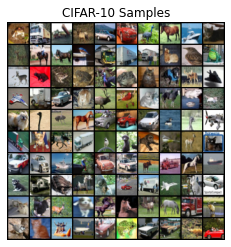

In [5]:
visualize_q1_data()

 We'll use the CIFAR-10 architecture from the [SN-GAN paper](https://arxiv.org/pdf/1802.05957.pdf), with $z \in \mathbb R ^{128}$, with $z \sim \mathcal N (0, I_{128})$. Instead of upsampling via transposed convolutions and downsampling via pooling or striding, we'll use these DepthToSpace and SpaceToDepth methods for changing the spatial configuration of our hidden states. 

```
class DepthToSpace(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, d_height, d_width, d_depth) = output.size()
        s_depth = int(d_depth / self.block_size_sq)
        s_width = int(d_width * self.block_size)
        s_height = int(d_height * self.block_size)
        t_1 = output.reshape(batch_size, d_height, d_width, self.block_size_sq, s_depth)
        spl = t_1.split(self.block_size, 3)
        stack = [t_t.reshape(batch_size, d_height, s_width, s_depth) for t_t in spl]
        output = torch.stack(stack, 0).transpose(0, 1).permute(0, 2, 1, 3, 4).reshape(batch_size, s_height, s_width,
                                                                                      s_depth)
        output = output.permute(0, 3, 1, 2)
        return output


class SpaceToDepth(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, s_height, s_width, s_depth) = output.size()
        d_depth = s_depth * self.block_size_sq
        d_width = int(s_width / self.block_size)
        d_height = int(s_height / self.block_size)
        t_1 = output.split(self.block_size, 2)
        stack = [t_t.reshape(batch_size, d_height, d_depth) for t_t in t_1]
        output = torch.stack(stack, 1)
        output = output.permute(0, 2, 1, 3)
        output = output.permute(0, 3, 1, 2)
        return output

# Spatial Upsampling with Nearest Neighbors
Upsample_Conv2d(in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
    x = torch.cat([x, x, x, x], dim=1)
    DepthToSpace(block_size=2)
    Conv2d(in_dim, out_dim, kernel_size, stride=stride, padding=padding)


# Spatial Downsampling with Spatial Mean Pooling
Downsample_Conv2d(in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
        SpaceToDepth(2)
        torch.sum(x.chunk(4, dim=1)) / 4.0
        nn.Conv2d(in_dim, out_dim, kernel_size,
                              stride=stride, padding=padding, bias=bias)
```

Here's pseudocode for how we'll implement a ResBlockUp, used in the generator:

```
ResnetBlockUp(x, in_dim, kernel_size=(3, 3), n_filters=256):
    _x = x
    _x = nn.BatchNorm2d(in_dim)(_x)
    _x = nn.ReLU()(_x)
    _x = nn.Conv2d(in_dim, n_filters, kernel_size, padding=1)(_x)
    _x = nn.BatchNorm2d(n_filters)(_x)
    _x = nn.ReLU()(_x)
    residual = Upsample_Conv2d(n_filters, n_filters, kernel_size, padding=1)(_x)
    shortcut = Upsample_Conv2d(in_dim, n_filters, kernel_size=(1, 1), padding=0)(x)
    return residual + shortcut
```
The ResBlockDown module is similar, except it uses Downsample_Conv2d and omits the BatchNorm.

Finally, here's the architecture for the generator:
```
def Generator(*, n_samples=1024, n_filters=128):
    z = Normal(0, 1)([n_samples, 128])
    nn.Linear(128, 4*4*256)
    reshape output of linear layer
    ResnetBlockUp(in_dim=256, n_filters=n_filters),
    ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
    ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
    nn.BatchNorm2d(n_filters),
    nn.ReLU(),
    nn.Conv2d(n_filters, 3, kernel_size=(3, 3), padding=1),
    nn.Tanh()
```
Again, the discriminator has the same architecture, except with ResnetBlockDown and no BatchNorm.

**Hyperparameters**

We'll implement [WGAN-GP](https://arxiv.org/abs/1704.00028), which uses a gradient penalty to regularize the discriminator. Use the Adam optimizer with $\alpha = 2e-4$, $\beta_1 = 0$, $\beta_2 = 0.9$, $\lambda = 10$, $n_{critic} = 5$. Use a batch size of 256 and n_filters=128 within the ResBlocks. Train for at least 25000 gradient steps, with the learning rate linearly annealed to 0 over training. 

**You will provide the following deliverables**
1. Inception score (CIFAR-10 version) of the final model. We provide a utility that will automatically do this for you.
2. Discriminator loss across training
3. 100 samples. 

## Solution

In [6]:
class DepthToSpace(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, inputs):
        output = inputs.permute(0, 2, 3, 1).contiguous()
        (batch_size, d_height, d_width, d_depth) = output.size()
        s_depth = int(d_depth / self.block_size_sq)
        s_height = int(d_height * self.block_size)
        s_width = int(d_width * self.block_size)
        t_1 = output.reshape(batch_size, d_height, d_width, self.block_size_sq, s_depth)
        spl = t_1.split(self.block_size, 3)
        stack = [t_t.reshape(batch_size, d_height, s_width, s_depth) for t_t in spl]
        output = torch.stack(stack, 0).transpose(0, 1).permute(0, 2, 1, 3, 4).\
                        reshape(batch_size, s_height, s_width, s_depth).contiguous()
        output = output.permute(0, 3, 1, 2).contiguous()
        return output

In [7]:
class SpaceToDepth(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, inputs):
        output = inputs.permute(0, 2, 3, 1).contiguous()
        (batch_size, s_height, s_width, s_depth) = output.size()
        d_depth = s_depth * self.block_size_sq
        d_height = int(s_height / self.block_size)
        d_width = int(s_width / self.block_size)
        t_1 = output.split(self.block_size, 2)
        stack = [t_t.reshape(batch_size, d_height, d_depth) for t_t in t_1]
        output = torch.stack(stack, 1)
        output = output.permute(0, 2, 1, 3).contiguous()
        output = output.permute(0, 3, 1, 2).contiguous()
        return output

In [8]:
class Upsample_Conv2d(nn.Module):
    def __init__(self, in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
        super().__init__()
        self.model = nn.Sequential(DepthToSpace(block_size=2), 
                                   nn.Conv2d(in_dim, out_dim, kernel_size, stride=stride, padding=padding))

    def forward(self, x):
        x = torch.cat([x, x, x, x], dim=1)
        x = self.model(x)
        return x


class Downsample_Conv2d(nn.Module):
    def __init__(self, in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
        super().__init__()
        self.down_sample = SpaceToDepth(2)
        self.conv = nn.Conv2d(in_dim, out_dim, kernel_size, stride=stride, padding=padding)

    def forward(self, x):
        x = self.down_sample(x)
        x = sum(x.chunk(4, dim=1)) / 4.0
        return self.conv(x)

In [9]:
class ResnetBlockUp(nn.Module):
    def __init__(self, in_dim, kernel_size=(3, 3), n_filters=256):
        super().__init__()
        self.model = nn.Sequential(nn.BatchNorm2d(in_dim), nn.ReLU(),
            nn.Conv2d(in_dim, n_filters, kernel_size, padding=1),
            nn.BatchNorm2d(n_filters), nn.ReLU(),
            Upsample_Conv2d(n_filters, n_filters, kernel_size, padding=1))
        self.up_sample = Upsample_Conv2d(in_dim, n_filters, kernel_size=(1, 1), padding=0)

    def forward(self, x):
        outs = self.model(x)
        shortcuts = self.up_sample(x)
        return outs + shortcuts


class ResnetBlockDown(nn.Module):
    def __init__(self, in_dim, kernel_size=(3, 3), n_filters=256):
        super().__init__()
        self.model = nn.Sequential(nn.ReLU(), nn.Conv2d(in_dim, n_filters, kernel_size, padding=1),
                                   nn.ReLU(), Downsample_Conv2d(n_filters, n_filters, kernel_size, padding=1))
        self.down_sample = Downsample_Conv2d(in_dim, n_filters, kernel_size=(1, 1), padding=0)

    def forward(self, x):
        outs = self.model(x)
        shortcuts = self.down_sample(x)
        return outs + shortcuts

In [10]:
class ImageGenerator(nn.Module):
    def __init__(self, n_filters=128):
        super().__init__()
        self.linear = nn.Linear(128, 4 * 4 * 256)
        self.model_after_reshape = nn.Sequential(ResnetBlockUp(in_dim=256, n_filters=n_filters),
                                                 ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
                                                 ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
                                                 nn.BatchNorm2d(n_filters), nn.ReLU(),
                                                 nn.Conv2d(n_filters, 3, kernel_size=(3, 3), padding=1), nn.Tanh())
    def forward(self, z):
        batch_size = z.shape[0]
        outs = self.linear(z)
        outs = outs.reshape(shape=(batch_size, 256, 4, 4))
        outs = self.model_after_reshape(outs)
        return outs

In [11]:
class ImageDiscriminator(nn.Module):
    def __init__(self, n_filters=128):
        super().__init__()
        self.linear = nn.Linear(128, 1)
        self.model_before_reshape = nn.Sequential(nn.Conv2d(3, n_filters, kernel_size=(3, 3), padding=1),
                                                  nn.ReLU(), ResnetBlockDown(in_dim=n_filters, n_filters=n_filters),
                                                  ResnetBlockDown(in_dim=n_filters, n_filters=n_filters),
                                                  ResnetBlockDown(in_dim=n_filters, n_filters=128))

    def forward(self, x):
        outs = self.model_before_reshape(x)
        outs = torch.mean(outs, dim=[2, 3])
        return self.linear(outs)

In [12]:
class WGAN_GP:
    def __init__(self, latent_dim, lr, batch_size, lmbda, device):
        self.d = ImageDiscriminator().to(device)
        self.g = ImageGenerator().to(device)
        self.batch_size = batch_size
        self.latent_dim = latent_dim
        self.lmbda = lmbda
        self.device = device
        self.d_optimizer = torch.optim.Adam(self.d.parameters(), lr=lr, betas=(0, 0.9))
        self.g_optimizer = torch.optim.Adam(self.g.parameters(), lr=lr, betas=(0, 0.9))

    def train_d(self, x):
        x = x.float().to(self.device)
        x = 2 * x - 1
        batch_size = x.shape[0]
        z = torch.normal(0, 1, size=(batch_size, self.latent_dim)).to(self.device)
        gz = self.g(z).detach()
        dx = self.d(x)
        dgz = self.d(gz)
        outs = torch.mean(dx - dgz)
        grad_pen = self.grad_pen(x, gz)
        outs = self.lmbda * grad_pen - outs
        self.d_optimizer.zero_grad()
        outs.backward()
        self.d_optimizer.step()
        return outs.cpu().item()

    def train_g(self, batch_size):
        self.freeze(self.d)
        z = torch.normal(0, 1, size=(batch_size, self.latent_dim)).to(self.device)
        gz = self.g(z)
        dgz = self.d(gz)
        outs = - torch.mean(dgz)
        self.g_optimizer.zero_grad()
        outs.backward()
        self.g_optimizer.step()
        self.reset(self.d)
        return outs.cpu().item()

    def grad_pen(self, real_data, fake_data):
        batch_size = real_data.shape[0]
        alpha = torch.rand(size=real_data.shape).to(self.device)
        interpolations = torch.tensor(alpha * real_data + (1 - alpha) * fake_data, requires_grad=True)
        outs = self.d(interpolations)
        gradients = torch.autograd.grad(outputs=outs, inputs=interpolations,
                                        grad_outputs=torch.ones(outs.size()).to(self.device),
                                        create_graph=True, retain_graph=True, only_inputs=True)[0]
        gradients = gradients.view(batch_size, - 1)
        return torch.mean((torch.norm(gradients, dim=1) - 1) ** 2)

    def sample(self, size):
        self.g.eval()
        z = torch.normal(0, 1, size=(size, self.latent_dim)).to(self.device)
        with torch.no_grad():
            gz = self.g(z)
        return (gz.permute(0, 2, 3, 1).cpu().numpy() + 1) / 2

    def score(self, x):
        x = torch.from_numpy(x).to(self.device).float()
        with torch.no_grad():
            dx = self.d(x)
        return dx.cpu().numpy()

    def freeze(self, sub_model):
        for param in sub_model.parameters():
            param.requires_grad = False

    def reset(self, sub_model):
        for param in sub_model.parameters():
            param.requires_grad = True

    def train(self):
        self.d.train()
        self.g.train()

    def eval(self):
        self.d.eval()
        self.g.eval()

In [13]:
def train(model, train_dataset, k, batch_size):
    train_loss = []
    model.train()
    for x, i in zip(train_dataset, range(len(train_data.dataset))):
        loss = model.train_d(x)
        train_loss.append(loss)
        if i % k == 0:
            model.train_g(batch_size)
    return train_loss

In [14]:
def training_epochs(model, train_dataset, training_args, tmp_model=None):
    train_loss = []
    epochs, lr, k, bs = training_args['epochs'], training_args['lr'], training_args["k"], training_args["bs"]
    for epoch in range(epochs):
        train_lo = train(model, train_dataset, k, bs)
        train_loss.extend(train_lo)
        if epoch == 0 and not (tmp_model is None):
            tmp_model.d.load_state_dict(model.d.state_dict())
            tmp_model.g.load_state_dict(model.g.state_dict())
    return train_loss

In [15]:
def q1(train_data):
    """
    train_data: An (n_train, 3, 32, 32) numpy array of CIFAR-10 images with values in [0, 1]

    Returns
    - a (# of training iterations,) numpy array of WGAN critic train losses evaluated every minibatch
    - a (1000, 32, 32, 3) numpy array of samples from your model in [0, 1]. 
        The first 100 will be displayed, and the rest will be used to calculate the Inception score. 
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    epochs = 20
    lr = 2e-4
    l = 10
    k = 5
    batch_size = 256
    latent_dim = 128
    
    model = WGAN_GP(latent_dim, lr, batch_size, l, device)
    tmp_model = WGAN_GP(latent_dim, lr, batch_size, l, device)
    
    train_dataset = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    train_loss = training_epochs(model, train_dataset, dict(epochs=epochs, lr=lr, k=k, bs=batch_size), tmp_model)
    
    s = model.sample(1000)
    return train_loss, s

## Results

Files already downloaded and verified
..........Inception score: 5.582112


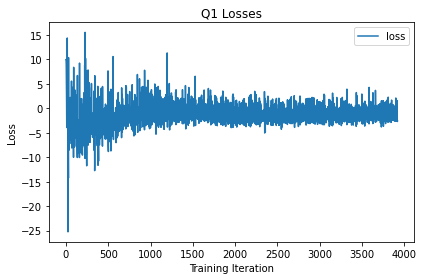

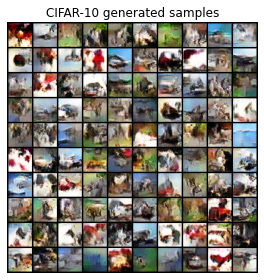

In [12]:
q1_save_results(q1)

# Question 2: Representation Learning with BiGAN on MNIST

In this part, we train a BiGAN on the MNIST dataset. Execute the cell below to visualize the dataset.

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


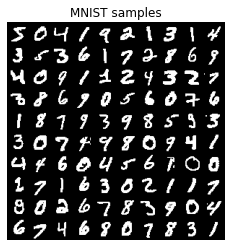

In [6]:
visualize_q2_data()

In BiGAN, in addition to training a generator $G$ and a discriminator $D$, we train an encoder $E$ that maps from real images $x$ to latent codes $z$. The discriminator now must learn to jointly identify fake $z$, fake $x$, and paired $(x, z)$ that don't belong together. In the original [BiGAN paper](https://arxiv.org/pdf/1605.09782.pdf), they prove that the optimal $E$ learns to invert the generative mapping $G: z \rightarrow x$. Our overall minimax term is now
$$V(D, E, G) = \mathbb{E}_{x \sim p_x}[\mathbb{E}_{z \sim p_E(\cdot | x)}[\log D(x, z)]] + \mathbb{E}_{z \sim p_z}[\mathbb{E}_{x \sim p_G(\cdot | z)}[\log (1 - D(x, z))]]$$

**Architecture**

We will closely follow the MNIST architecture outlined in the original BiGAN paper, Appendix C.1, with one modification: instead of having $z \sim \text{Uniform}[-1, 1]$, we use $z \sim \mathcal N (0, 1)$ with $z \in \mathbb R ^{50}$. 

**Hyperparameters**

We make several modifications to what is listed in the BiGAN paper. We apply $l_2$ weight decay to all weights and decay the step size $\alpha$ linearly to 0 over the course of training. Weights are initialized via the default PyTorch manner. We recommend training for at least 100 epochs -- this part is much less computationally expensive than previous homeworks. 

**Reconstructions**

You should take the first 20 images from the MNIST training set and then display the reconstructions $x_{recon} = G(E(x))$. It's ok if your reconstructions are somewhat lossy; ours are too. We will provide a utility to show these. 

**Testing the representation**

We want to see how good a linear classifier $L$ we can learn such that 
$$y \approx L(E(x))$$
where $y$ is the appropriate label. Fix $E$ and learn a weight matrix $W$ such that your linear classifier is composed of passing $x$ through $E$, then multiplying by $W$, then applying a softmax nonlinearity. Train this via gradient descent with the cross-entropy loss. 

As a baseline, randomly initialize another network $E_{random}$ with the same architecture, fix its weights, and train a linear classifier on top, as done in the previous part.


**You will provide the following deliverables**
1. Plot of the minimax loss term. 
2. 100 samples from the BiGAN
3. A comparison of MNIST images $x$ with their reconstructions $G(E(x))$.
4. Test loss plot for the linear classifier trained on the pretrained encoder, and a randomly initialized encoder. 
5. Final test losses for the two linear classifiers. 

**Feel free to train the networks separately, save the necessary information, and simply use our function to generate the appropriate figures.**


In [16]:
class LinClassify(nn.Module):
    def __init__(self, feature_num, label_num):
        super().__init__()
        self.linear = nn.Linear(feature_num, label_num)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.criteria = nn.CrossEntropyLoss()

    def forward(self, x, encoder):
        encoder.eval()
        e_x = encoder(x).detach()
        outs = self.linear(e_x)
        return outs

    def loss(self, x, labels, encoder):
        x = x.reshape(x.shape[0], -1).float().to(self.device)
        labels = labels.to(self.device)
        outs = self(x, encoder)
        return self.criteria(outs, labels)

    def predict(self, x, encoder):
        x = x.reshape(x.shape[0], -1).float().to(self.device)
        outs = self(x, encoder)
        return torch.argmax(outs, dim=1)


def training_classifier(classifier, encoder, epoch, train_loader, test_loader):
    optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-3)
    train_losses = []
    eval_losses = []
    for i in range(epoch):
        for x, label in train_loader:
            loss = classifier.loss(x, label, encoder)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_losses.append(loss.cpu().item())
        eval_losses.append(evaluate_classifier(classifier, encoder, test_loader))
    return train_losses, eval_losses


def evaluate_classifier(classifier, encoder, test_loader):
    eval_loss = 0
    for x, label in test_loader:
        with torch.no_grad():
            loss = classifier.loss(x, label, encoder)
        eval_loss += loss.cpu().item() * x.shape[0]
    return eval_loss / len(test_loader.dataset)


def evaluate_acc(classifier, encoder, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    true_num = 0
    for x, label in test_loader:
        with torch.no_grad():
            pred = classifier.predict(x, encoder)
            true_num += torch.sum(pred.squeeze() == label.to(device).squeeze()).cpu().item()
    return true_num / len(test_loader.dataset)

In [17]:
class EncoderBi(nn.Module):
    def __init__(self, inputs_dim, hidden_dim, outs_dim):
        super().__init__()
        self.model = nn.Sequential(nn.Linear(inputs_dim, hidden_dim), nn.LeakyReLU(0.2),
                                   nn.Linear(hidden_dim, hidden_dim), nn.BatchNorm1d(hidden_dim), nn.LeakyReLU(0.2),
                                   nn.Linear(hidden_dim, outs_dim))

    def forward(self, inputs):
        return self.model(inputs)

In [18]:
class GeneratorBi(nn.Module):
    def __init__(self, inputs_dim, hidden_dim, outs_dim):
        super().__init__()
        self.inputs_dim = inputs_dim
        self.model = nn.Sequential(nn.Linear(inputs_dim, hidden_dim), nn.ReLU(),
                                   nn.Linear(hidden_dim, hidden_dim), nn.BatchNorm1d(hidden_dim), nn.ReLU(),
                                   nn.Linear(hidden_dim, outs_dim), nn.Tanh())
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def forward(self, inputs):
        return self.model(inputs)

    def sample(self, batch_size):
        x = torch.normal(0, 1, size=(batch_size, self.inputs_dim)).to(self.device)
        x = self.model(x)
        x = (x + 1) / 2
        return x.reshape(batch_size, 28, 28).unsqueeze(-1).cpu().numpy()

In [19]:
class DiscriminatorBi(nn.Module):
    def __init__(self, inputs_dim, hidden_dim, outs_dim):
        super().__init__()
        self.model = nn.Sequential(nn.Linear(inputs_dim, hidden_dim), nn.LeakyReLU(0.2),
                                   nn.Linear(hidden_dim, hidden_dim), nn.BatchNorm1d(hidden_dim), nn.LeakyReLU(0.2),
                                   nn.Linear(hidden_dim, outs_dim), nn.Sigmoid())

    def forward(self, inputs):
        return self.model(inputs)

In [20]:
class BiGAN:
    def __init__(self, real_data_dim, latent_dim, lr, device):
        self.device = device
        self.latent_dim = latent_dim
        self.g = GeneratorBi(latent_dim, 1024, real_data_dim).to(device)
        self.e = EncoderBi(real_data_dim, 1024, latent_dim).to(device)
        self.d = DiscriminatorBi(real_data_dim + latent_dim, 1024, 1).to(device)
        self.d_optimizer = torch.optim.Adam(self.d.parameters(), 
                                            lr=lr, betas=(0.5, 0.999), weight_decay=2.5 * 1e-5)
        self.g_e_optimizer = torch.optim.Adam(list(self.g.parameters()) + list(self.e.parameters()), 
                                              lr=lr, betas=(0.5, 0.999), weight_decay=2.5 * 1e-5)

    def train_d(self, x):
        x = x.reshape(x.shape[0], -1).float().to(self.device)
        z = torch.normal(0, 1, size=(x.shape[0], self.latent_dim)).to(self.device)
        gz = self.g(z).detach()
        ex = self.e(x).detach()
        z_gz = torch.cat((z, gz), dim=-1)
        ex_x = torch.cat((ex, x), dim=-1)
        d_z_gz = self.d(z_gz)
        d_ex_x = self.d(ex_x)
        loss = - torch.mean(torch.log(d_ex_x) + torch.log(1 - d_z_gz))
        self.d_optimizer.zero_grad()
        loss.backward()
        self.d_optimizer.step()
        return loss.item()

    def train_g_e(self, x):
        self.freeze(self.d)
        x = x.reshape(x.shape[0], -1).float().to(self.device)
        z = torch.normal(0, 1, size=(x.shape[0], self.latent_dim)).to(self.device)
        gz = self.g(z)
        ex = self.e(x)
        z_gz = torch.cat((z, gz), dim=-1)
        ex_x = torch.cat((ex, x), dim=-1)
        d_z_gz = self.d(z_gz)
        d_ex_x = self.d(ex_x)
        loss = torch.mean(torch.log(d_ex_x) + torch.log(1 - d_z_gz))
        self.g_e_optimizer.zero_grad()
        loss.backward()
        self.g_e_optimizer.step()
        self.reset(self.d)
        return loss.item()

    def sample(self, batch_size):
        self.g.eval()
        with torch.no_grad():
            outs = self.g.sample(batch_size)
        return outs

    def reconstruction(self, x):
        self.g.eval()
        self.e.eval()
        x = x.float().to(self.device).reshape(x.shape[0], -1)
        with torch.no_grad():
            e_x = self.e(x)
            g_e_x = self.g(e_x)
        x = (x + 1) / 2
        g_e_x = (g_e_x + 1) / 2
        image_list = []
        for i in range(x.shape[0]):
            image_list.append(x[i].reshape(28, 28).unsqueeze(-1))
        for i in range(x.shape[0]):
            image_list.append(g_e_x[i].reshape(28, 28).unsqueeze(-1))
        results = torch.stack(image_list, dim=0)
        return results.cpu().numpy()

    def freeze(self, sub_model):
        for param in sub_model.parameters():
            param.requires_grad = False

    def reset(self, sub_model):
        for param in sub_model.parameters():
            param.requires_grad = True

    def train(self):
        self.d.train()
        self.g.train()

    def eval(self):
        self.d.eval()
        self.g.eval()

## Solution

In [21]:
def q2(train_data, test_data):
    """
    train_data: A PyTorch dataset that contains (n_train, 28, 28) MNIST digits, normalized to [-1, 1]
                Documentation can be found at torchvision.datasets.MNIST
    test_data: A PyTorch dataset that contains (n_test, 28, 28) MNIST digits, normalized to [-1, 1]
                Documentation can be found at torchvision.datasets.MNIST

    Returns
    - a (# of training iterations,) numpy array of BiGAN minimax losses evaluated every minibatch
    - a (100, 28, 28, 1) numpy array of BiGAN samples that lie in [0, 1]
    - a (40, 28, 28, 1) numpy array of 20 real image / reconstruction pairs
    - a (# of training epochs,) numpy array of supervised cross-entropy losses on the BiGAN encoder evaluated every epoch 
    - a (# of training epochs,) numpy array of supervised cross-entropy losses on a random encoder evaluated every epoch 
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_bi_gan_losses = []
    lr = 2e-4
    epochs = 50
    classifier_epoch = 30
    k = 1
    label_num = 10
    batch_size = 128
    latent_dim = 50
    feature_num = 28 * 28
    
    bi_gan = BiGAN(feature_num, latent_dim, lr, device)
    train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_data_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
    
    for i in range(epochs):
        j = 0
        for x, _ in train_data_loader:
            d_loss = bi_gan.train_d(x)
            train_bi_gan_losses.append(d_loss)
            if j % k == 0:
                g_e_loss = bi_gan.train_g_e(x)
            j += 1

    samples = bi_gan.sample(100)
    reconstruction = bi_gan.reconstruction(torch.from_numpy(2 * (train_data.train_data.numpy()[0:20] / 255) - 1).unsqueeze(1))
    trained_encoder = bi_gan.e
    trained_classifier = LinClassy(latent_dim, label_num).to(device)
    random_encoder = BiGAN(feature_num, latent_dim, lr, device).e
    random_classifier = LinClassify(latent_dim, label_num).to(device)
    _, trained_eval_losses = training_classifier(trained_classifier, trained_encoder, classifier_epoch,
                                                 train_data_loader, test_data_loader)
    _, random_eval_losses = training_classifier(random_classifier, random_encoder, classifier_epoch,
                                                train_data_loader, test_data_loader)
    trained_acc = evaluate_acc(trained_classifier, trained_encoder, test_data_loader)
    random_acc = evaluate_acc(random_classifier, random_encoder, test_data_loader)
    return train_bi_gan_losses, samples, reconstruction, trained_eval_losses, random_eval_losses

## Results

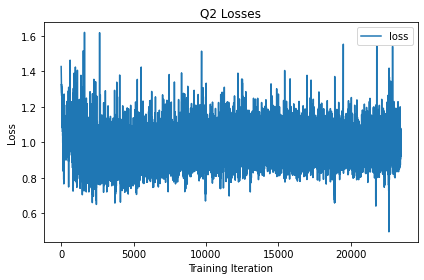

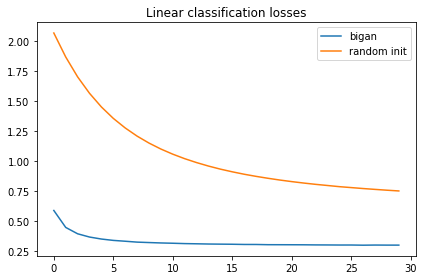

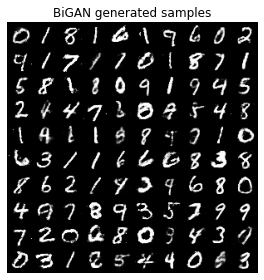

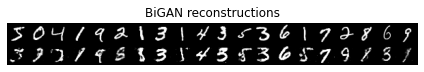

BiGAN final linear classification loss: 0.30203228142261507
Random encoder linear classification loss: 0.7529142497062683


In [15]:
q2_save_results(q2)

# Bonus 5: CycleGAN
In this question, you'll train a CycleGAN model to learn to translate between two different image domains, without any paired data. Execute the following cell to visualize our two datasets: MNIST and Colored MNIST. 

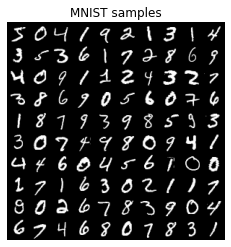

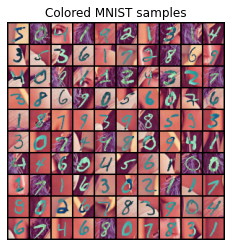

In [ ]:
visualize_cyclegan_datasets()

In [CycleGAN](https://arxiv.org/pdf/1703.10593.pdf), the goal is to learn functions $F$ and $G$ that can transform images from $X \rightarrow Y$ and vice-versa. This is an unconstrained problem, so we additionally enforce the *cycle-consistency* property, where we want 
$$x \approx G(F(x))$$
and  
$$y \approx F(G(x))$$
This loss function encourages $F$ and $G$ to approximately invert each other. In addition to this cycle-consistency loss, we also have a standard GAN loss such that $F(x)$ and $G(y)$ look like real images from the other domain. 

Since this is a bonus question, we won't do much hand-holding. We recommend reading through the original paper to get a sense of what architectures and hyperparameters are useful. Note that our datasets are fairly simple, so you won't need excessively large models. 

**You will report the following deliverables**
1. A set of images showing real MNIST digits, transformations of those images into Colored MNIST digits, and reconstructions back into the greyscale domain. 
2. A set of images showing real Colored MNIST digits, transformations of those images, and reconstructions. 

## Solution

In [ ]:
def b5(mnist_data, cmnist_data):
    """
    mnist_data: An (60000, 1, 28, 28) numpy array of black and white images with values in [0, 1]
    cmnist_data: An (60000, 3, 28, 28) numpy array of colored images with values in [0, 1]

    Returns
    - a (20, 28, 28, 1) numpy array of real MNIST digits, in [0, 1]
    - a (20, 28, 28, 3) numpy array of translated Colored MNIST digits, in [0, 1]
    - a (20, 28, 28, 1) numpy array of reconstructed MNIST digits, in [0, 1]

    - a (20, 28, 28, 3) numpy array of real Colored MNIST digits, in [0, 1]
    - a (20, 28, 28, 1) numpy array of translated MNIST digits, in [0, 1]
    - a (20, 28, 28, 3) numpy array of reconstructed Colored MNIST digits, in [0, 1]
    """
    """ YOUR CODE HERE """

## Results

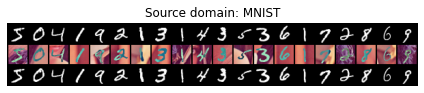

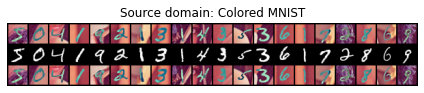

In [ ]:
b5_save_results(b5)